### * **What is a phishing attack?**
* Phishing is a type of social engineering attack often used to steal user data, including login credentials and credit card numbers. It occurs when an attacker, masquerading as a trusted entity, dupes a victim into opening an email, instant message, or text message. 

##### * Importing some useful libraries

In [ ]:
!pip install selenium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.3 MB 7.5 MB/s 
     |████████████████████████████████| 384 kB 68.9 MB/s 
     |████████████████████████████████| 140 kB 78.1 MB/s 
     |████████████████████████████████| 58 kB 6.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.13 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np 

import seaborn as sns  
import matplotlib.pyplot as plt 
%matplotlib inline 

import plotly.express as px
import time 

from sklearn.linear_model import LogisticRegression # algo use to predict good or bad
from sklearn.naive_bayes import MultinomialNB # nlp algo use to predict good or bad

from sklearn.model_selection import train_test_split # spliting the data between feature and target
from sklearn.metrics import classification_report # gives whole report about metrics (e.g, recall,precision,f1_score,c_m)
from sklearn.metrics import confusion_matrix # gives info about actual and predict
from nltk.tokenize import RegexpTokenizer # regexp tokenizers use to split words from text  
from nltk.stem.snowball import SnowballStemmer # stemmes words
from sklearn.feature_extraction.text import CountVectorizer # create sparse matrix of words using regexptokenizes  
from sklearn.pipeline import make_pipeline # use for combining all prerocessors techniuqes and algos

from PIL import Image # getting images in notebook
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator# creates words colud

from bs4 import BeautifulSoup # use for scraping the data from website
from selenium import webdriver # use for automation chrome 
import networkx as nx # for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

import pickle# use to dump model 

import warnings # ignores pink warnings 
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/mydrive")

Mounted at /content/mydrive


In [ ]:
# Loading the dataset
phish_data = pd.read_csv('/content/mydrive/MyDrive/project/phishing_site_urls.csv')

In [ ]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [ ]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [ ]:
phish_data.isnull().sum() # there is no missing values

URL      0
Label    0
dtype: int64

* **Since it is classification problems so let's see the classes are balanced or imbalances**

In [ ]:
#create a dataframe of classes counts
label_counts = pd.DataFrame(phish_data.Label.value_counts())

In [ ]:
#visualizing target_col
fig = px.bar(label_counts, x=label_counts.index, y=label_counts.Label)
fig.show()

### Preprocessing
* **Now that we have the data, we have to vectorize our URLs. I used CountVectorizer and gather words using tokenizer, since there are words in urls that are more important than other words e.g ‘virus’, ‘.exe’ ,’.dat’ etc. Lets convert the URLs into a vector form.**

#### RegexpTokenizer
* A tokenizer that splits a string using a regular expression, which matches either the tokens or the separators between tokens.

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')#to getting alpha only

In [ ]:
phish_data.URL[0]

'nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'

In [ ]:
# this will be pull letter which matches to expression
tokenizer.tokenize(phish_data.URL[0]) # using first row

['nobell',
 'it',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'login',
 'SkyPe',
 'com',
 'en',
 'cgi',
 'bin',
 'verification',
 'login',
 'ffb',
 'd',
 'dca',
 'cce',
 'f',
 'index',
 'php',
 'cmd',
 'profile',
 'ach',
 'outdated',
 'page',
 'tmpl',
 'p',
 'gen',
 'failed',
 'to',
 'load',
 'nav',
 'login',
 'access']

In [ ]:
print('Getting words tokenized ...')
t0= time.perf_counter()
phish_data['text_tokenized'] = phish_data.URL.map(lambda t: tokenizer.tokenize(t)) # doing with all rows
t1 = time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words tokenized ...
Time taken 2.9017901500000107 sec


In [ ]:
phish_data.sample(5)

,URL,Label,text_tokenized
447022,threestooges.net/episode.php?id=408,good,"[threestooges, net, episode, php, id]"
142717,answers.yahoo.com/question/index?qid=200711080...,good,"[answers, yahoo, com, question, index, qid, AA..."
273389,amazon.ca/Mon-Oncle-Antoine-Jacques-Gagnon/dp/...,good,"[amazon, ca, Mon, Oncle, Antoine, Jacques, Gag..."
22680,dopuskotsro.ru/add.conter.strike.GLLOball.Offe...,bad,"[dopuskotsro, ru, add, conter, strike, GLLObal..."
95029,www.gamereport.com/tgr8/picktwo.html,good,"[www, gamereport, com, tgr, picktwo, html]"


#### SnowballStemmer
* Snowball is a small string processing language, gives root words

In [ ]:
stemmer = SnowballStemmer("english") # choose a language

In [ ]:
print('Getting words stemmed ...')
t0= time.perf_counter()
phish_data['text_stemmed'] = phish_data['text_tokenized'].map(lambda l: [stemmer.stem(word) for word in l])
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting words stemmed ...
Time taken 53.823116156 sec


In [ ]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed
436989,spokeo.com/Missy+Lynn,good,"[spokeo, com, Missy, Lynn]","[spokeo, com, missi, lynn]"
186962,faqs.ign.com/objects/566/566342.html,good,"[faqs, ign, com, objects, html]","[faq, ign, com, object, html]"
338074,findagrave.com/cgi-bin/fg.cgi?page=gr&GRid=699...,good,"[findagrave, com, cgi, bin, fg, cgi, page, gr,...","[findagrav, com, cgi, bin, fg, cgi, page, gr, ..."
473661,youtube.com/watch?v=NSzOPApC3Ag,good,"[youtube, com, watch, v, NSzOPApC, Ag]","[youtub, com, watch, v, nszopapc, ag]"
375889,linkedin.com/pub/alexandra-stewart/8/917/3b7,good,"[linkedin, com, pub, alexandra, stewart, b]","[linkedin, com, pub, alexandra, stewart, b]"


In [ ]:
print('Getting joiningwords ...')
t0= time.perf_counter()
phish_data['text_sent'] = phish_data['text_stemmed'].map(lambda l: ' '.join(l))
t1= time.perf_counter() - t0
print('Time taken',t1 ,'sec')

Getting joiningwords ...
Time taken 0.2708246910000014 sec


In [ ]:
phish_data.sample(5)

,URL,Label,text_tokenized,text_stemmed,text_sent
126034,infighter.co.uk/cscom-charity/validate/73392/,bad,"[infighter, co, uk, cscom, charity, validate]","[infight, co, uk, cscom, chariti, valid]",infight co uk cscom chariti valid
420625,realadventures.com/g186822_west-long-branch-je...,good,"[realadventures, com, g, west, long, branch, j...","[realadventur, com, g, west, long, branch, jer...",realadventur com g west long branch jersey sho...
446982,thoroughbredvillage.com.au/,good,"[thoroughbredvillage, com, au]","[thoroughbredvillag, com, au]",thoroughbredvillag com au
428938,searchpeopledirectory.com/canada-postal-codes/AB/,good,"[searchpeopledirectory, com, canada, postal, c...","[searchpeopledirectori, com, canada, postal, c...",searchpeopledirectori com canada postal code ab
134898,labelsandmore.com/wp-admin/user/msn/default.php,bad,"[labelsandmore, com, wp, admin, user, msn, def...","[labelsandmor, com, wp, admin, user, msn, defa...",labelsandmor com wp admin user msn default php


### Visualization 
**1. Visualize some important keys using word cloud**

In [ ]:
#sliceing classes
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [ ]:
bad_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"[nobell, it, ffb, d, dca, cce, f, login, SkyPe...","[nobel, it, ffb, d, dca, cce, f, login, skype,...",nobel it ffb d dca cce f login skype com en cg...
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"[www, dghjdgf, com, paypal, co, uk, cycgi, bin...","[www, dghjdgf, com, paypal, co, uk, cycgi, bin...",www dghjdgf com paypal co uk cycgi bin webscrc...
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"[serviciosbys, com, paypal, cgi, bin, get, int...","[serviciosbi, com, paypal, cgi, bin, get, into...",serviciosbi com paypal cgi bin get into herf s...
3,mail.printakid.com/www.online.americanexpress....,bad,"[mail, printakid, com, www, online, americanex...","[mail, printakid, com, www, onlin, americanexp...",mail printakid com www onlin americanexpress c...
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"[thewhiskeydregs, com, wp, content, themes, wi...","[thewhiskeydreg, com, wp, content, theme, wide...",thewhiskeydreg com wp content theme widescreen...


In [ ]:
good_sites.head()

,URL,Label,text_tokenized,text_stemmed,text_sent
18231,esxcc.com/js/index.htm?us.battle.net/noghn/en/...,good,"[esxcc, com, js, index, htm, us, battle, net, ...","[esxcc, com, js, index, htm, us, battl, net, n...",esxcc com js index htm us battl net noghn en r...
18232,wwweira¯&nvinip¿ncH¯wVö%ÆåyDaHðû/ÏyEùuË\nÓ6...,good,"[www, eira, nvinip, ncH, wV, yDaH, yE, u, rT, ...","[www, eira, nvinip, nch, wv, ydah, ye, u, rt, ...",www eira nvinip nch wv ydah ye u rt u g m i xz...
18233,'www.institutocgr.coo/web/media/syqvem/dk-óij...,good,"[www, institutocgr, coo, web, media, syqvem, d...","[www, institutocgr, coo, web, media, syqvem, d...",www institutocgr coo web media syqvem dk ij r ...
18234,Yìê koãÕ»Î§DéÎl½ñ¡ââqtò¸/à; Í,good,"[Y, ko, D, l, qt]","[y, ko, d, l, qt]",y ko d l qt
18236,ruta89fm.com/images/AS@Vies/1i75cf7b16vc<Fd16...,good,"[ruta, fm, com, images, AS, Vies, i, cf, b, vc...","[ruta, fm, com, imag, as, vie, i, cf, b, vc, f...",ruta fm com imag as vie i cf b vc f d b g sd v...


* create a function to visualize the important keys from url 

In [ ]:
def plot_wordcloud(text, mask=None, max_words=400, max_font_size=120, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'com','http'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'green', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '../input/masks/masks-wordclouds/'

In [ ]:
data = good_sites.text_sent
data.reset_index(drop=True, inplace=True)

In [ ]:
data = bad_sites.text_sent
data.reset_index(drop=True, inplace=True)

### Creating Model
#### CountVectorizer
* CountVectorizer is used to transform a corpora of text to a vector of term / token counts.

In [ ]:
#create cv object
cv = CountVectorizer()

In [ ]:
help(CountVectorizer())

Help on CountVectorizer in module sklearn.feature_extraction.text object:

class CountVectorizer(_VectorizerMixin, sklearn.base.BaseEstimator)
 |  CountVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), analyzer='word', max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.int64'>)
 |  
 |  Convert a collection of text documents to a matrix of token counts.
 |  
 |  This implementation produces a sparse representation of the counts using
 |  scipy.sparse.csr_matrix.
 |  
 |  If you do not provide an a-priori dictionary and you do not use an analyzer
 |  that does some kind of feature selection then the number of features will
 |  be equal to the vocabulary size found by analyzing the data.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----

In [ ]:
feature = cv.fit_transform(phish_data.text_sent) #transform all text which we tokenize and stemed

In [ ]:
feature

<549346x350836 sparse matrix of type '<class 'numpy.int64'>'
	with 3676059 stored elements in Compressed Sparse Row format>

In [ ]:
feature[:5].toarray() # convert sparse matrix into array to print transformed features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
feature.shape

(549346, 350836)

#### * Spliting the data 

In [ ]:
trainX, testX, trainY, testY = train_test_split(feature, phish_data.Label)

### LogisticRegression
* Logistic Regression is a Machine Learning classification algorithm that is used to predict the probability of a categorical dependent variable. In logistic regression, the dependent variable is a binary variable that contains data coded as 1 (yes, success, etc.) or 0 (no, failure, etc.). In other words, the logistic regression model predicts P(Y=1) as a function of X.

In [ ]:
# create lr object
lr = LogisticRegression()

In [ ]:
lr.fit(trainX,trainY)

LogisticRegression()

In [ ]:
lr.score(testX,testY)

0.9637533949336304

.*** Logistic Regression is giving 96% accuracy, Now we will store scores in dict to see which model perform best**

In [ ]:
Scores_ml = {}
Scores_ml['Logistic Regression'] = np.round(lr.score(testX,testY),2)

Training Accuracy : 0.9778912596569492
Testing Accuracy : 0.9637533949336304

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.90      0.97      0.93     36542
        Good       0.99      0.96      0.97    100795

    accuracy                           0.96    137337
   macro avg       0.95      0.96      0.95    137337
weighted avg       0.97      0.96      0.96    137337


CONFUSION MATRIX


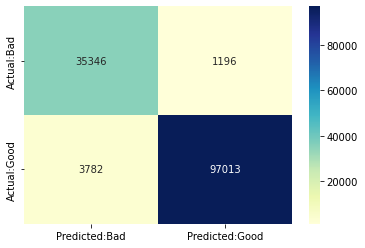

In [ ]:
print('Training Accuracy :',lr.score(trainX,trainY))
print('Testing Accuracy :',lr.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(lr.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(lr.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### MultinomialNB
* Applying Multinomial Naive Bayes to NLP Problems. Naive Bayes Classifier Algorithm is a family of probabilistic algorithms based on applying Bayes' theorem with the “naive” assumption of conditional independence between every pair of a feature.

In [ ]:
# create mnb object
mnb = MultinomialNB()

In [ ]:
mnb.fit(trainX,trainY)

MultinomialNB()

In [ ]:
mnb.score(testX,testY)

0.9575715211487072

*** MultinomialNB gives us 95% accuracy**  

In [ ]:
Scores_ml['MultinomialNB'] = np.round(mnb.score(testX,testY),2)

Training Accuracy : 0.9739131912166967
Testing Accuracy : 0.9575715211487072

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.94      0.92     38185
        Good       0.98      0.97      0.97     99152

    accuracy                           0.96    137337
   macro avg       0.94      0.95      0.95    137337
weighted avg       0.96      0.96      0.96    137337


CONFUSION MATRIX


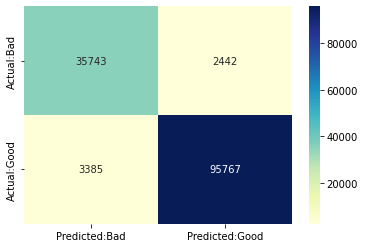

In [ ]:
print('Training Accuracy :',mnb.score(trainX,trainY))
print('Testing Accuracy :',mnb.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(mnb.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(mnb.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### Stochastic Gradient Descent

In [ ]:
trainX, testX, trainY, testY = train_test_split(feature , phish_data['Label'])

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(loss = 'modified_huber', shuffle = True, random_state = 101)
sgd.fit(trainX, trainY)
y_pred = sgd.predict(testX)

In [ ]:
Scores_ml['SGDClasssifier'] = np.round(sgd.score(testX,testY),2)

In [ ]:
sgd.score(testX, testY)

0.9511857693119844

Training Accuracy : 0.9595931156843661
Testing Accuracy : 0.9511857693119844

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.86      0.97      0.91     34859
        Good       0.99      0.95      0.97    102478

    accuracy                           0.95    137337
   macro avg       0.92      0.96      0.94    137337
weighted avg       0.96      0.95      0.95    137337


CONFUSION MATRIX


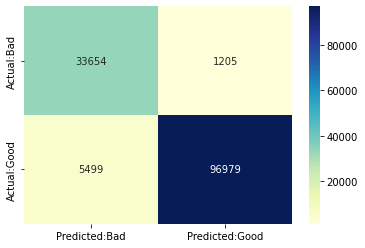

In [ ]:
print('Training Accuracy :',sgd.score(trainX,trainY))
print('Testing Accuracy :',sgd.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(sgd.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(sgd.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(trainX, trainY)
y_pred = knn.predict(testX)

In [ ]:
Scores_ml['KNeighborsClassifier'] = np.round(knn.score(testX,testY),2)

In [ ]:
knn.score(testX, testY)

0.8937795350124147

In [ ]:
confusion_matrix(y_pred, testY)

array([[35220, 10655],
       [ 3933, 87529]])

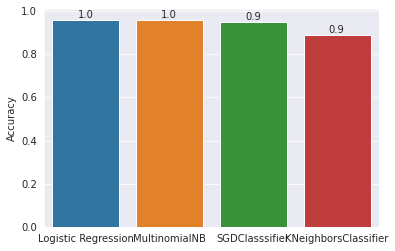

In [ ]:
acc = pd.DataFrame.from_dict(Scores_ml,orient = 'index',columns=['Accuracy'])
sns.set_style('darkgrid')
ax1 = sns.barplot(acc.index,acc.Accuracy)

for p in ax1.patches:
   ax1.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.30, p.get_height()+0.01))

*** So, Logistic Regression is the best fit model, Now we make sklearn pipeline using Logistic Regression**

In [ ]:
  pipeline_ls = make_pipeline(CountVectorizer(tokenizer = RegexpTokenizer(r'[A-Za-z]+').tokenize,stop_words='english'), LogisticRegression())
##(r'\b(?:http|ftp)s?://\S*\w|\w+|[^\w\s]+') ([a-zA-Z]+)([0-9]+)  -- these tolenizers giving me low accuray 

In [ ]:
trainX, testX, trainY, testY = train_test_split(phish_data.URL, phish_data.Label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words='english',
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('logisticregression', LogisticRegression())])

In [ ]:
pipeline_ls.score(testX,testY)

0.9668552538645813

Training Accuracy : 0.9803450895490147
Testing Accuracy : 0.9668552538645813

CLASSIFICATION REPORT

              precision    recall  f1-score   support

         Bad       0.91      0.97      0.94     36973
        Good       0.99      0.97      0.98    100364

    accuracy                           0.97    137337
   macro avg       0.95      0.97      0.96    137337
weighted avg       0.97      0.97      0.97    137337


CONFUSION MATRIX


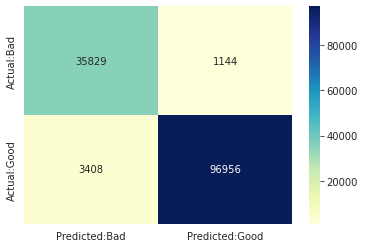

In [ ]:
print('Training Accuracy :',pipeline_ls.score(trainX,trainY))
print('Testing Accuracy :',pipeline_ls.score(testX,testY))
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])


print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [ ]:
pickle.dump(pipeline_ls,open('phishing.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9668552538645813


***That’s it. See, it's that simple yet so effective. We get an accuracy of 96%. That’s a very high value for a machine to be able to detect a malicious URL with. Want to test some links to see if the model gives good predictions? Sure. Let's do it**

* Bad links => this are phishing sites
yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php
fazan-pacir.rs/temp/libraries/ipad
www.tubemoviez.exe
svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt

* Good links => this are not phishing sites
www.youtube.com/
youtube.com/watch?v=qI0TQJI3vdU
www.retailhellunderground.com/
restorevisioncenters.com/html/technology.html

In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('phishing.pkl', 'rb'))
#predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("*"*30)
print(result2)

['bad' 'bad' 'bad' 'bad']
******************************
['good' 'good' 'good' 'good']


### ROC Curve

In [ ]:
Y = phish_data.Label

In [ ]:
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
le = LabelEncoder()
Y = le.fit_transform(Y)

In [ ]:
trainX, testX, trainY, testY = train_test_split(feature,Y)

In [ ]:
#fit logistic regression model and plot ROC curve
model = LogisticRegression()
model.fit(trainX, trainY)

LogisticRegression()

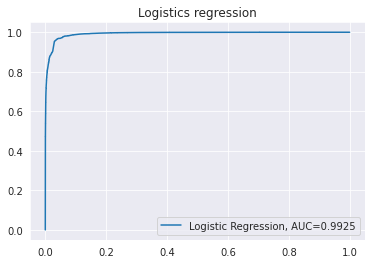

In [ ]:
#set up plotting area
plt.figure(0).clf()

y_pred = model.predict_proba(testX)[:, 1]
fpr, tpr, _ = metrics.roc_curve(testY, y_pred)
auc = round(metrics.roc_auc_score(testY, y_pred), 4)
plt.plot(fpr,tpr,label="Logistic Regression, AUC="+str(auc))
plt.title("Logistics regression")
plt.legend()

In [ ]:
#fit Multinomial NaiveBayes and plot ROC curve
model1 = MultinomialNB()
model1.fit(trainX, trainY)

MultinomialNB()

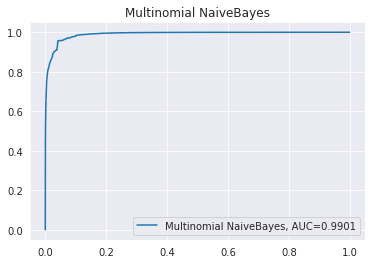

In [ ]:
#set up plotting area
plt.figure(0).clf()

y_pred = model1.predict_proba(testX)[:, 1]
fpr, tpr, _ = metrics.roc_curve(testY, y_pred)
auc = round(metrics.roc_auc_score(testY, y_pred), 4)
plt.plot(fpr,tpr,label="Multinomial NaiveBayes, AUC="+str(auc))
plt.title("Multinomial NaiveBayes")
plt.legend()

In [ ]:
#fit SGD and plot ROC curve
model2 = SGDClassifier(loss = 'hinge')
model2.fit(trainX, trainY)

SGDClassifier()

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

base_model = SGDClassifier()
model = CalibratedClassifierCV(base_model)

model.fit(trainX, trainY)
model.predict_proba(trainX)

array([[5.61025267e-01, 4.38974733e-01],
       [1.63984026e-05, 9.99983602e-01],
       [9.63531165e-02, 9.03646883e-01],
       ...,
       [8.13891396e-01, 1.86108604e-01],
       [4.59298977e-03, 9.95407010e-01],
       [1.15510682e-02, 9.88448932e-01]])

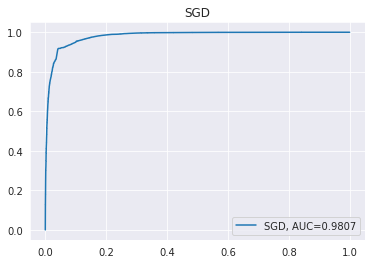

In [ ]:
#set up plotting area

clf = SGDClassifier(loss='hinge')
plt.figure(0).clf()
y_pred = model.predict_proba(testX)[:, 1]
fpr, tpr, _ = metrics.roc_curve(testY, y_pred)
auc = round(metrics.roc_auc_score(testY, y_pred), 4)
plt.plot(fpr,tpr,label="SGD, AUC="+str(auc))
plt.title("SGD")
plt.legend()

In [ ]:
#fit KNN and plot ROC curve
model3 = KNeighborsClassifier()
model3.fit(trainX, trainY)

KNeighborsClassifier()

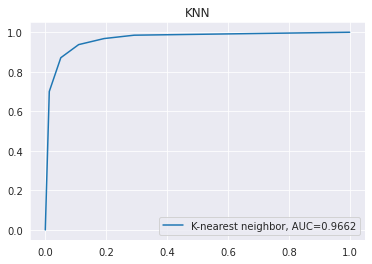

In [ ]:
#set up plotting area
plt.figure(0).clf()

y_pred = model3.predict_proba(testX)[:, 1]
fpr, tpr, _ = metrics.roc_curve(testY, y_pred)
auc = round(metrics.roc_auc_score(testY, y_pred), 4)
plt.plot(fpr,tpr,label="K-nearest neighbor, AUC="+str(auc))
plt.title("KNN")
plt.legend()

In [ ]:
'''# Logistic regression ROC/ AUC , BEST MODEL
from sklearn import metrics
fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
probs = lr.predict_proba(testX)
preds = probs[:,1]
fprlr, tprlr, thresholdlr = metrics.roc_curve(testY, preds)
roc_auclr = metrics.auc(fprlr, tprlr)

ax.plot(fprlr, tprlr, 'b', label = 'AUC = %0.2f' % roc_auclr)
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('Receiver Operating Characteristic Logistic Regression ',fontsize=10)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.legend(loc = 'lower right', prop={'size': 16})

# Multinomial NaiveBayes
probs = mnb.predict_proba(testX)
preds = probs[:,1]
fprmnb, tprmnb, thresholdmnb = metrics.roc_curve(testY, preds)
roc_aucmnb = metrics.auc(fprmnb, tprmnb)

ax1.plot(fprmnb, tprmnb, 'b', label = 'AUC = %0.2f' % roc_aucmnb)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic Multinomial NaiveBayes ',fontsize=10)
ax1.set_ylabel('True Positive Rate',fontsize=20)
ax1.set_xlabel('False Positive Rate',fontsize=15)
ax1.legend(loc = 'lower right', prop={'size': 16})

# sgd
probs = sgd.predict_proba(testX)
preds = probs[:,1]
fprsgd, tprsgd, thresholdsgd = metrics.roc_curve(testY, preds)
roc_aucsgd = metrics.auc(fprsgd, tprsgd)

ax1.plot(fprsgd, tprsgd, 'b', label = 'AUC = %0.2f' % roc_aucsgd)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic SGD ',fontsize=10)
ax1.set_ylabel('True Positive Rate',fontsize=20)
ax1.set_xlabel('False Positive Rate',fontsize=15)
ax1.legend(loc = 'lower right', prop={'size': 16})

# Multinomial NaiveBayes
probs = mnb.predict_proba(testX)
preds = probs[:,1]
fprmnb, tprmnb, thresholdmnb = metrics.roc_curve(testY, preds)
roc_aucmnb = metrics.auc(fprmnb, tprmnb)

ax1.plot(fprmnb, tprmnb, 'b', label = 'AUC = %0.2f' % roc_aucmnb)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic Multinomial NaiveBayes ',fontsize=10)
ax1.set_ylabel('True Positive Rate',fontsize=20)
ax1.set_xlabel('False Positive Rate',fontsize=15)
ax1.legend(loc = 'lower right', prop={'size': 16})'''

plt.subplots_adjust(wspace=1)'''

In [ ]:
'''from sklearn.metrics import roc_curve, roc_auc_score

# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(random_state=1234), 
               MultinomialNB(), 
               SGDClassifier(),
               KNeighborsClassifier()]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(trainX, trainY)
    yproba = model.predict(testX)
    
    fpr, tpr, _ = roc_curve(testY,  yproba)
    auc = roc_auc_score(testY, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)'''

In [ ]:
'''fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()'''

In [ ]:
#fig.savefig('multiple_roc_curve.png')